In [1]:
import torch
import numpy as np
import h5py
import sys
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy.table import Table
from matplotlib import mlab as mlab
from astroNN.shared.matplotlib import pylab_style
pylab_style(paper=True)

sys.path.append("..") # add higher direc to path
from xp_vae.model import ScatterVAE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using %s' % device)
torch.cuda.empty_cache()

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] =r"\usepackage{xcolor} "

import matplotlib as mpl

Using cpu


## Load data from XP/APOGEE cross-match

In [2]:
APOGEE_XP_XMATCH_PATH = '../data/xp_apogee_cat.h5'
f = h5py.File(APOGEE_XP_XMATCH_PATH,'r')['__astropy_table__']

# flux normalization
g_flux = f['phot_g_mean_flux'][:,np.newaxis]
xp = f['coeffs']/g_flux
xp_err = f['coeff_errs']/g_flux

# standard normalization
norm = np.load('../data/apogee_norm.npz')
xp_norm = (xp - norm['mu']) / norm['sig']
xp_err_norm = xp_err / norm['sig']

# stellar labels + photometry
teff = f['TEFF']
logg = f['LOGG']
m_h = f['M_H']

# errors
teff_err = f['TEFF_ERR']
logg_err = f['LOGG_ERR']
m_h_err = f['M_H_ERR']

# other data for cuts
bp_rp = f['GAIAEDR3_PHOT_BP_MEAN_MAG'] - f['GAIAEDR3_PHOT_RP_MEAN_MAG']
mean_mag = f['GAIAEDR3_PHOT_G_MEAN_MAG']
starflag = f['STARFLAG']
aspcapflag = f['ASPCAPFLAG']

## Get test indices

In [3]:
from sklearn.model_selection import train_test_split
validation_split = 0.1 # default value

# split up xp data to match training (see xp_vae.model.fit), by index
idx = np.arange(len(xp))
idx_train,idx_val = train_test_split(idx,test_size=validation_split,random_state=12345)

## Load *s*VAE

In [4]:
from xp_vae.model import ScatterVAE

model = ScatterVAE().to(device)
weights = torch.load('../models/APOGEE_MODEL/weight.pt',map_location=device)
model.load_state_dict(state_dict=weights['model_state_dict'])
model.eval()

ScatterVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=110, out_features=90, bias=True)
      (1): BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (1): Sequential(
      (0): Linear(in_features=90, out_features=70, bias=True)
      (1): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (2): Sequential(
      (0): Linear(in_features=70, out_features=50, bias=True)
      (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (3): Sequential(
      (0): Linear(in_features=50, out_features=30, bias=True)
      (1): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
    )
    (4): Sequential(
      (0): Linear(in_features=30, out_features=10, bias=True)
      (1): Batc

In [5]:
in1 = torch.from_numpy(xp_norm).cpu().to(device)
in2 = torch.from_numpy(xp_err_norm).to(device)

_,_,mu,log_var,est,s = model.forward(in1,in2)

est = est.detach().cpu().numpy()*norm['sig']+norm['mu']
s = s.detach().cpu().numpy()*norm['sig']
latent = model.reparam(mu.cpu().to(device),log_var.cpu().to(device)).cpu().detach().numpy()

## Load large astronomy model - [Leung & Bovy (2023)](https://arxiv.org/abs/2308.10944)

You will need to download their [model](https://github.com/henrysky/astroNN_stars_foundation) to run this notebook

In [6]:
import sys
sys.path.append('../../astroNN_stars_foundation')
from stellarperceptron.model import StellarPerceptron

lam_model = StellarPerceptron.load("../../astroNN_stars_foundation/model_torch", mixed_precision=False, device=device)
# can only perceive 32 first BP and 32 first RP coeffs because of length 64 context window
xp_list = [f"bp{i}" for i in range(32)] + [f"rp{i}" for i in range(32)] 

### Stellar label dependent implementation of LB23

File available at https://zenodo.org/records/10951393

In [6]:
# Perceive XP, request labels, perceive labels, request XP

'''
lam_model.perceive(xp[:,np.r_[0:32,55:87]][idx_val],xp_list) # perceive the normalized XP spectra (but only 64 coeffs)
print('Perceived XP')
label_names = ['teff','logg','m_h','jh','jk']
res_int = lam_model.request(label_names) # request stellar labels + J-H & J-k
print('Requested labels')
lam_model.clear_perception() # forget normalized XP spectra
print('Cleared perception')
lb23_labels = np.column_stack([res_int[col] for col in label_names])
lam_model.perceive(lb23_labels,['teff','logg','m_h','jh','jk']) # perceive stellar labels + J-H & J-k
print('Perceived labels')
res = lam_model.request(xp_list) # request the normalized XP spectra (but only 64 coeffs)
print('Requested XP')

lam_bp_est = np.array([res[f"bp{i}"].to_numpy() for i in range(32)])
lam_rp_est = np.array([res[f"rp{i}"].to_numpy() for i in range(32)])
lam_est_labels = np.concatenate((lam_bp_est,lam_rp_est)).T

np.save('../data/lb23_xp_est_labels.npy',lam_est_labels)
'''

lam_est_labels = np.load('../data/lb23_xp_est_labels.npy')

### Stellar label independent implementation of LB23

File available at https://zenodo.org/records/10951393

In [7]:
# Perceive XP, request XP
'''
lam_model.perceive(xp[:,np.r_[0:32,55:87]][idx_val],xp_list) # perceive the normalized XP spectra (but only 64 coeffs)
print('Perceived XP')
res = lam_model.request(xp_list) # request the normalized XP spectra (but only 64 coeffs)
print('Requested XP')

lam_bp_est = np.array([res[f"bp{i}"].to_numpy() for i in range(32)])
lam_rp_est = np.array([res[f"rp{i}"].to_numpy() for i in range(32)])
lam_est_no_labels = np.concatenate((lam_bp_est,lam_rp_est)).T

np.save('../data/lb23_xp_est_no_labels.npy', lam_est_no_labels)
'''
lam_est_no_labels = np.load('../data/lb23_xp_est_no_labels.npy')

## Compute reconstructions errors to compare with LB23

In [8]:
# Note: only first 32 BP and RP coefficients

# For the sVAE...
model_err_star = np.sqrt(np.sum( (((est[idx_val]-xp[idx_val])/xp_err[idx_val])**2.)[:,np.r_[0:32,55:87]], axis=1)/64)
model_err_coeff = np.sqrt(np.sum( (((est[idx_val]-xp[idx_val])/xp_err[idx_val])**2.)[:,np.r_[0:32,55:87]], axis=0)/110)

# ...for the stellar label dependent implementation...
lam_err_star_labels = np.sqrt(np.sum( ( (lam_est_labels-xp[idx_val][:,np.r_[0:32,55:87]])/ xp_err[idx_val][:,np.r_[0:32,55:87]] )**2., axis=1)/64) 
lam_err_coeff_labels = np.sqrt(np.sum( ( (lam_est_labels-xp[idx_val][:,np.r_[0:32,55:87]])/ xp_err[idx_val][:,np.r_[0:32,55:87]] )**2., axis=0)/110)

lam_err_star_no_labels = np.sqrt(np.sum( ( (lam_est_no_labels-xp[idx_val][:,np.r_[0:32,55:87]])/ xp_err[idx_val][:,np.r_[0:32,55:87]] )**2., axis=1)/64) 
lam_err_coeff_no_labels = np.sqrt(np.sum( ( (lam_est_no_labels-xp[idx_val][:,np.r_[0:32,55:87]])/ xp_err[idx_val][:,np.r_[0:32,55:87]] )**2., axis=0)/110)

In [9]:
# now compute the mean coefficient error (again, for 64 coefficients)

# sVAE
model_err_coeff_mean = np.mean( (((est[idx_val]-xp[idx_val])/xp_err[idx_val])**2.)[:,np.r_[0:32,55:87]], axis=0)
# LB23 - stellar label dependent
lam_err_coeff_mean_labels = np.mean( ((lam_est_labels-xp[idx_val][:,np.r_[0:32,55:87]])/xp_err[idx_val][:,np.r_[0:32,55:87]])**2., axis=0)
# LB23 - stellar label independent
lam_err_coeff_mean_no_labels = np.mean( ((lam_est_no_labels-xp[idx_val][:,np.r_[0:32,55:87]])/xp_err[idx_val][:,np.r_[0:32,55:87]])**2., axis=0)

## Compare reconstructions errors to LB23 as a function of coefficients

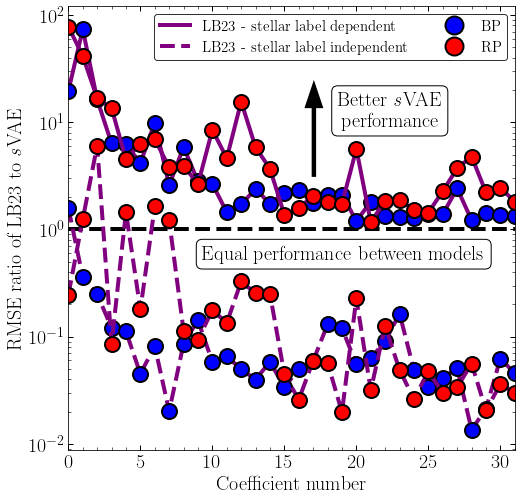

In [10]:
fig,ax = plt.subplots(figsize=(8,8),sharex=False,sharey=False)
lw=4
ms=15

# models have equivalent performance at ratio = 1
ax.axhline(1,ls='--',c='k',lw=lw)

coeff_nums = np.arange(32)
# full catalog - LB23 stellar label dependent
ax.plot(coeff_nums,lam_err_coeff_mean_labels[:32]/model_err_coeff_mean[:32],lw=lw,
        c='purple',marker='o',markersize=ms,markeredgecolor='k',markeredgewidth=2,
        markerfacecolor='b')
ax.plot(lam_err_coeff_mean_labels[32:]/model_err_coeff_mean[32:],lw=lw,
        c='purple',marker='o',markersize=ms,markeredgecolor='k',markeredgewidth=2,
        markerfacecolor='r')
# full catalog - LB23 stellar label independent
ax.plot(coeff_nums,lam_err_coeff_mean_no_labels[:32]/model_err_coeff_mean[:32],lw=lw,
        c='purple',marker='o',markersize=ms,markeredgecolor='k',markeredgewidth=2,ls='--',
        markerfacecolor='b')
ax.plot(lam_err_coeff_mean_no_labels[32:]/model_err_coeff_mean[32:],lw=lw,
        c='purple',marker='o',markersize=ms,markeredgecolor='k',markeredgewidth=2,ls='--',
        markerfacecolor='r')

ax.set_yscale('log')
#ax.set_xscale('log')

ax.set_ylabel(r'RMSE ratio of LB23 to \emph{s}VAE')
ax.set_xlabel(r'Coefficient number')
ax.set_xlim(0,31)
#ax.set_ylim(10**-0.3,10**2)

from matplotlib.lines import Line2D
leg_elements = [Line2D([0], [0], color='purple', lw=lw, label='LB23 - stellar label dependent'),
                Line2D([0], [0], color='purple', lw=lw, label='LB23 - stellar label independent',ls='--'),
                Line2D([0], [0], color='w', markerfacecolor='b',markeredgewidth=2,markeredgecolor='k', marker='o',label='BP'),
                Line2D([0], [0], color='w', markerfacecolor='r',markeredgewidth=2,markeredgecolor='k', marker='o',label='RP')]
leg = ax.legend(handles=leg_elements, loc='upper right',fontsize=15,ncol=2)
leg.get_frame().set_edgecolor('k')

# arrow explaining plot
ax.arrow(0.55,0.62,0,0.2,fc='k',ec='k',transform=ax.transAxes,length_includes_head=True,lw=lw,head_width=0.03)
ax.text(0.72,0.73,'Better \emph{s}VAE\nperformance',
        transform=ax.transAxes,fontsize=20,horizontalalignment='center',bbox=dict(facecolor='none', edgecolor='k',boxstyle='round'))

ax.text(0.3,0.43,'Equal performance between models',
        transform=ax.transAxes,fontsize=20,c='k',bbox=dict(facecolor='none', edgecolor='k',boxstyle='round'))

plt.savefig('../figures/compare_lam.png',dpi=400,bbox_inches='tight')
plt.show()

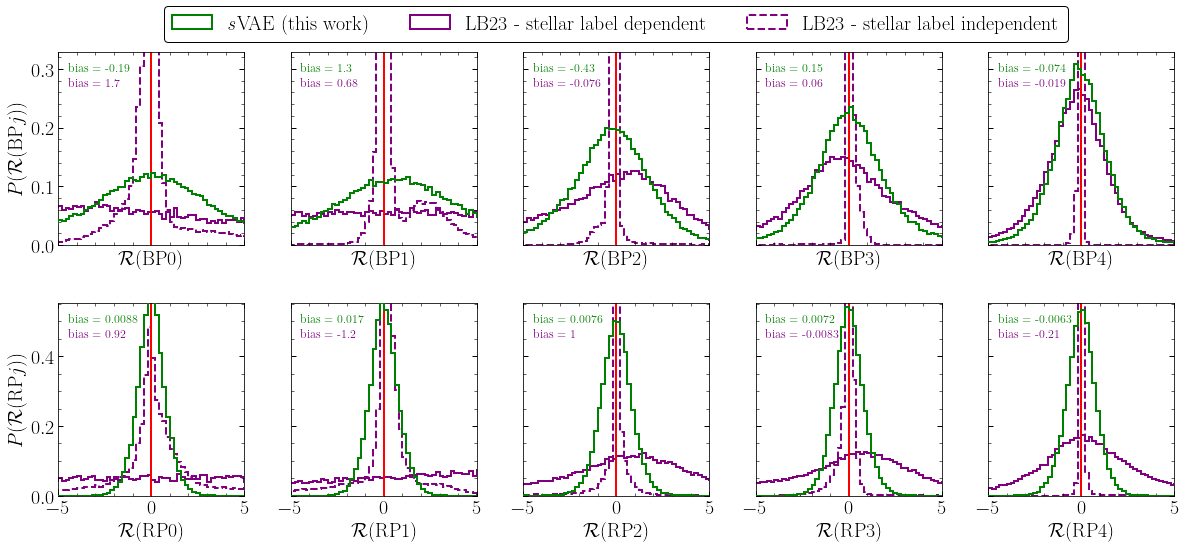

In [11]:
fig,ax=plt.subplots(2,5,figsize=(20,8),sharex=True,sharey='row')
plt.subplots_adjust(hspace=.3,wspace=.25)
coeffs = [0,1,2,3,4,32,33,34,35,36]
nbins = 101
lw = 2

color='green'
for i,coeff in enumerate(coeffs):

    if coeff < 32: 
        ax.flatten()[i].set_xlabel(r'$\mathcal{R}(\mathrm{BP}%s)$' % coeff)
    if coeff >= 32: 
        ax.flatten()[i].set_xlabel(r'$\mathcal{R}(\mathrm{RP}%s)$' % (coeff-32))

    model_err = (est[idx_val][:,coeff]-xp[idx_val][:,coeff])/xp_err[idx_val][:,coeff]
    sig_lim = 10
    bins = np.linspace(-sig_lim,sig_lim,nbins)
    n,_,_ = ax.flatten()[i].hist(model_err,
                        bins=bins,alpha=1,density=True,histtype=u'step',lw=lw,zorder=3,color=color,label=r' \emph{s}VAE (this work)')
    ax.flatten()[i]
    
    # stellar label dependent
    foundation_model_err = (lam_est_labels[:,coeff]-xp[idx_val][:,np.r_[0:32,55:87]][:,coeff])/xp_err[idx_val][:,np.r_[0:32,55:87]][:,coeff]
    ax.flatten()[i].hist(foundation_model_err,
                        bins=bins,alpha=1,density=True,color='purple',histtype=u'step',lw=lw,zorder=1,label=r'LB23 - stellar label dependent')
    
    # stellarlabel independent
    foundation_model_err = (lam_est_no_labels[:,coeff]-xp[idx_val][:,np.r_[0:32,55:87]][:,coeff])/xp_err[idx_val][:,np.r_[0:32,55:87]][:,coeff]
    ax.flatten()[i].hist(foundation_model_err,
                        bins=bins,alpha=1,density=True,color='purple',histtype=u'step',ls='--',lw=lw,zorder=1,label=r'LB23 - stellar label independent')

    ax.flatten()[i].set_xlim(-sig_lim,sig_lim)
    ax.flatten()[i].set_ylim(0.,np.max(n)+0.02)
    ax.flatten()[i].axvline(0,c='red',lw=lw)

    ax.flatten()[i].text(.05,.9,
                        r'bias = %.2g' % np.mean(model_err), 
                        transform=ax.flatten()[i].transAxes,fontsize=12,c=color)
    ax.flatten()[i].text(.05,.825,
                        r'bias = %.2g' % np.mean(foundation_model_err), 
                        transform=ax.flatten()[i].transAxes,fontsize=12,c='purple')

ax.flatten()[0].set_ylabel(r'$P(\mathcal{R}(\mathrm{BP}j))$')
ax.flatten()[5].set_ylabel(r'$P(\mathcal{R}(\mathrm{RP}j))$')

ax.flatten()[0].set_xlim(-5,5)

leg2 = ax[1,4].legend(fontsize=20,framealpha=1,loc='lower right',bbox_to_anchor=(.48,2.3),ncol=3)
leg2.get_frame().set_edgecolor('k')

plt.savefig('../figures/lam_coeff_errs.png',dpi=400,bbox_inches='tight')
plt.show()

## Compare with deep stellar label model - [Zhang, Green, Rix (2023)](https://arxiv.org/abs/2303.03420)

You will need to download their [model](https://zenodo.org/records/7811871) to run this notebook.

File available at https://zenodo.org/records/10951393

In [13]:
import tensorflow as tf

zhang_nn_model = tf.saved_model.load("../../stellar_flux_model")
zhang_sample_wavelengths = zhang_nn_model._sample_wavelengths.numpy()

# optimized stellar labels from ZGR23, cross-matched to APOGEE (see scripts.cross_match_zhang.py)
zhang_xmatch = np.load('../data/zhang_stellar_params_xmatch.npz',allow_pickle=True)
zhang_stellar_param_vecs = zhang_xmatch['stellar_params']
zhang_quality_flags = zhang_xmatch['quality_flags']

# maskt to remove stars which fail quality cut, as reccomended by Zhang et al. 2023
quality_cut = zhang_quality_flags < 8
print('%s stars left after quality cut (from %s test stars)' % (np.sum(quality_cut),len(quality_cut)))

zhang_est = zhang_nn_model.predict_observed_flux(zhang_stellar_param_vecs[:,:3],
                                                 zhang_stellar_param_vecs[:,3],
                                                 100*zhang_stellar_param_vecs[:,4]).numpy()

37302 stars left after quality cut (from 50232 test stars)


### Convert XP coefficients to wavelengths for ZGR23 comparison

Files available at https://zenodo.org/records/10951393

In [14]:
# see scripts.convert_to_wavelength.py

from gaiaxpy.core.config import _load_xpmerge_from_xml, _load_xpsampling_from_xml
xp_sampling_grid, xp_merge = _load_xpmerge_from_xml()
xp_design_matrices = _load_xpsampling_from_xml()

wavelength_mask_xp = np.array([lam in zhang_sample_wavelengths for lam in xp_sampling_grid]) 
wavelength_mask_zhang = np.array([lam in xp_sampling_grid for lam in zhang_sample_wavelengths])

vae_wavelength_space = np.load('../data/vae_wavelength_space.npy')
xp_wavelength_space = np.load('../data/xp_wavelength_space.npy')[idx_val]
err_wavelength_space = np.abs(np.load('../data/err_wavelength_space.npy'))

## Compare reconstruction errors to ZGR23 as a function of wavelength

In [15]:
# compute rmse in wavelength space

model_err_star_wavelength = np.sqrt(np.nanmean( ( ( (vae_wavelength_space-xp_wavelength_space)/err_wavelength_space )[quality_cut]**2.), axis=0))
zhang_err_star_wavelength = np.sqrt(np.nanmean( ( ( (zhang_est[:,:-5]/1e22-xp_wavelength_space)/err_wavelength_space )[quality_cut]**2.), axis=0))

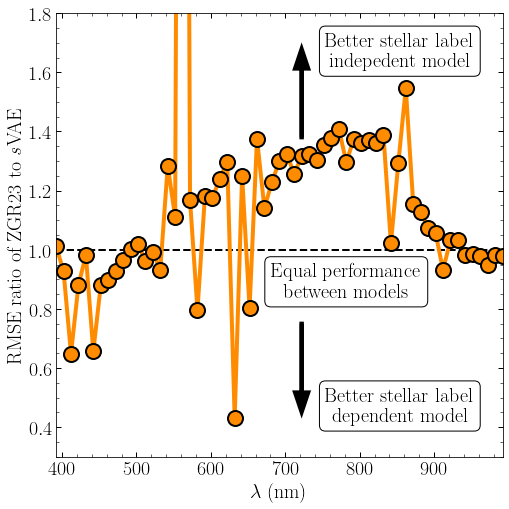

In [17]:
fig,ax = plt.subplots(figsize=(8,8),sharex=False,sharey=False)
lw=4

# equal model performance
ax.axhline(1,c='k',ls='--',lw=2)

# full catalog
ax.plot(zhang_sample_wavelengths[:-5],zhang_err_star_wavelength/model_err_star_wavelength,lw=lw,c='darkorange',
        label='Full catalog',marker='o',markersize=ms,markeredgecolor='k',markeredgewidth=2)

#ax.set_yscale('log')
ax.set_ylim(.3,1.8)
ax.set_xlim(zhang_sample_wavelengths[:-5][0],zhang_sample_wavelengths[:-5][-1])

ax.set_xlabel(r'$\lambda$ (nm)')
ax.set_ylabel(r'RMSE ratio of ZGR23 to \emph{s}VAE')

# arrows explaining plot
ax.arrow(0.55,0.72,0,0.2,fc='k',ec='k',transform=ax.transAxes,length_includes_head=True,lw=lw,head_width=0.03)
ax.text(0.77,0.88,'Better stellar label\n indepedent model',
        transform=ax.transAxes,fontsize=20,bbox=dict(facecolor='none', edgecolor='k',boxstyle='round'),horizontalalignment='center')

ax.arrow(0.55,0.3,0,-0.2,fc='k',ec='k',transform=ax.transAxes,length_includes_head=True,lw=lw,head_width=0.03)
ax.text(0.77,0.08,'Better stellar label \n dependent model',
        transform=ax.transAxes,fontsize=20,horizontalalignment='center',bbox=dict(facecolor='none', edgecolor='k',boxstyle='round'))

ax.text(0.65,0.36,'Equal performance \n between models',
        transform=ax.transAxes,fontsize=20,c='k',bbox=dict(facecolor='none', edgecolor='k',boxstyle='round'),horizontalalignment='center')

plt.savefig('../figures/compare_zgr.png',dpi=400,bbox_inches='tight')
plt.show()

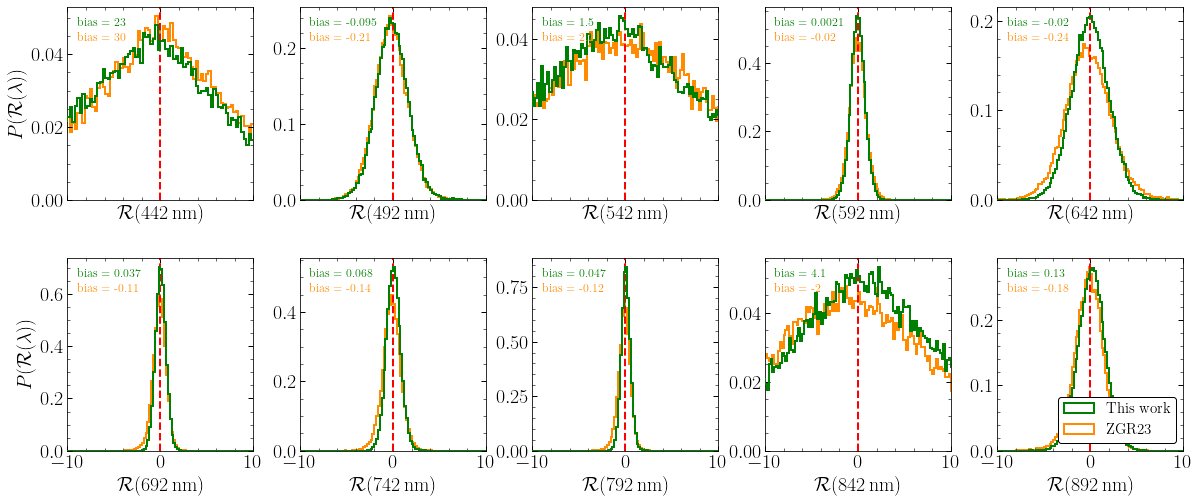

In [18]:
fig,ax=plt.subplots(2,5,figsize=(20,8),sharex=True,sharey=False)
plt.subplots_adjust(hspace=.3,wspace=.25)
coeffs = [5,10,15,20,25,30,35,40,45,50] # not actually coeffs, they are now wavelength idxs
color = 'green'
nbins = 201
lw = 2
for i,coeff in enumerate(coeffs):

    ax.flatten()[i].set_xlabel(r'$\mathcal{R}(%s\,\mathrm{nm})$' % int(zhang_sample_wavelengths[coeff]))

    model_err = ((vae_wavelength_space[:,coeff]-xp_wavelength_space[:,coeff])/err_wavelength_space[:,coeff])[quality_cut]
    sig_lim = (abs(np.percentile(model_err, 1.)) + np.percentile(model_err, 99.))/2
    sig_lim = 20
    if i==0 or i==2: # these wavelengths have huge tails for both models, trim sides
        sig_lim = (abs(np.percentile(model_err, 10.)) + np.percentile(model_err, 90.))/2
    bins = np.linspace(-sig_lim,sig_lim,nbins)
    ax.flatten()[i].hist(model_err,
                        bins=bins,alpha=1,density=True,histtype=u'step',lw=lw,zorder=3,color=color,label=r'This work')
    ax.flatten()[i]
    
    zgr_err = ((zhang_est[:,coeff]/1e22-xp_wavelength_space[:,coeff])/err_wavelength_space[:,coeff])[quality_cut]
    ax.flatten()[i].hist(zgr_err,
                        bins=bins,alpha=1,density=True,color='darkorange',histtype=u'step',lw=lw,zorder=1,label=r'ZGR23')

    ax.flatten()[i].set_xlim(-sig_lim,sig_lim)
    ax.flatten()[i].axvline(0,c='r',ls='--',lw=lw)

    if i==0 or i==5:
        ax.flatten()[i].set_ylabel(r'$P(\mathcal{R}(\lambda))$')
        ax.flatten()[i].set_ylabel(r'$P(\mathcal{R}(\lambda))$')

    ax.flatten()[i].text(.05,.9,
                        r'bias = %.2g' % np.mean(model_err), 
                        transform=ax.flatten()[i].transAxes,fontsize=12,c=color)
    ax.flatten()[i].text(.05,.825,
                        r'bias = %.2g' % np.nanmean(zgr_err), 
                        transform=ax.flatten()[i].transAxes,fontsize=12,c='darkorange')

#leg1 = ax[0,4].legend(fontsize=15,framealpha=1,loc='lower right')
leg2 = ax[1,4].legend(fontsize=15,framealpha=1,loc='lower right')
#leg1.get_frame().set_edgecolor('k')
leg2.get_frame().set_edgecolor('k')

ax.flatten()[0].set_xlim(-10,10)

plt.savefig('../figures/zgr_rel_errs.png',dpi=400,bbox_inches='tight')
plt.show()

## Error distributions as a function of stellar labels

In [19]:
# Need to first compute total error for each test star

model_err = np.sqrt(np.sum( (((est[idx_val]-xp[idx_val])/xp_err[idx_val])**2.)[:,np.r_[0:32,55:87]], axis=1)/64)
lam_err_labels = np.sqrt(np.sum( ((lam_est_labels-xp[idx_val][:,np.r_[0:32,55:87]])/xp_err[idx_val][:,np.r_[0:32,55:87]])**2., axis=1)/110)
lam_err_no_labels = np.sqrt(np.sum( ((lam_est_no_labels-xp[idx_val][:,np.r_[0:32,55:87]])/xp_err[idx_val][:,np.r_[0:32,55:87]])**2., axis=1)/110)

# IMPORTANT: do not include quality cut for our model to show that we can model M-dwarfs!
model_err_wavelength = np.sqrt(np.nanmean( ((vae_wavelength_space-xp_wavelength_space)/err_wavelength_space)**2., axis=1))
zhang_err = np.sqrt(np.nanmean( ((zhang_est[:,:-5]/1e22-xp_wavelength_space)/err_wavelength_space)**2., axis=1))[quality_cut]

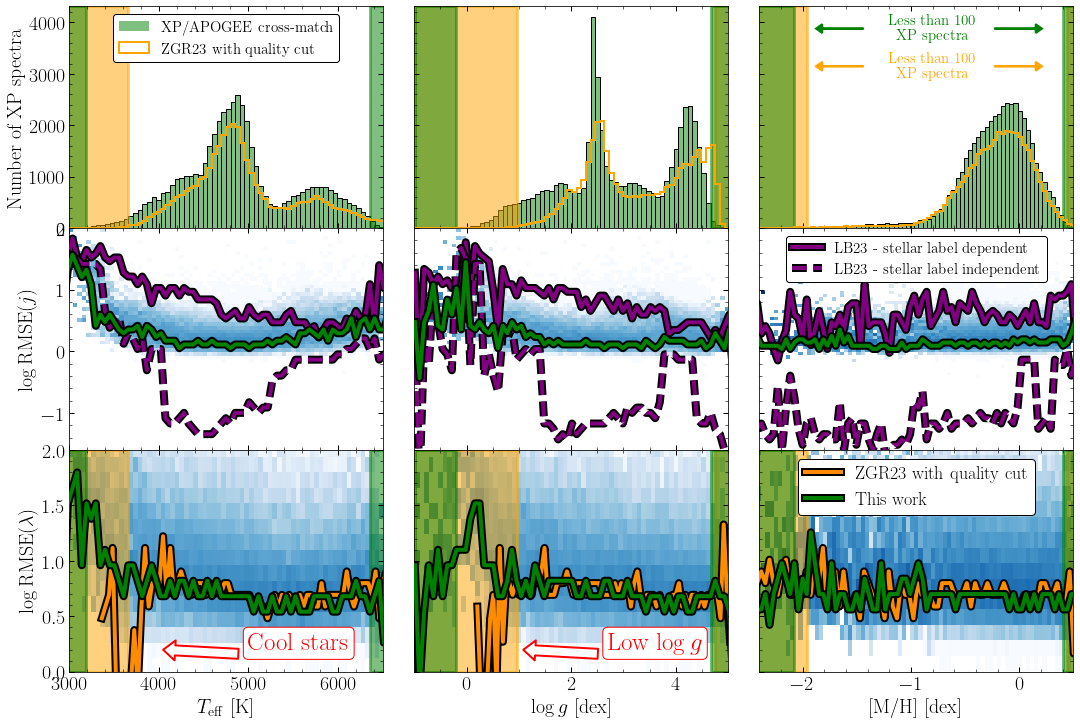

In [35]:
fig, ax = plt.subplots(3,3,figsize=(18,12),sharex='col',sharey='row')
plt.subplots_adjust(wspace=0.1,hspace=0.)

bins_x = 80
bins_y = 50
vae_color = 'Blues'
mode_color='green'
lam_color = 'purple'
zhang_color = 'darkorange'
lw = 4

import matplotlib.patheffects as mpe
outline=mpe.withStroke(linewidth=8, foreground='k')

# LB23 errors as function of stellar labels (coeffs) - for stellar label dependent model
for i,stellar_label in enumerate([teff,logg,m_h]):
    x = stellar_label[idx_val][np.isfinite(stellar_label[idx_val])]
    y = np.log10(lam_err_labels)[np.isfinite(stellar_label[idx_val])]
    hist,xedges,yedges = np.histogram2d(x,y,bins=(bins_x,bins_y))
    hist = hist.T
    X,Y = np.meshgrid(xedges,yedges)
    with np.errstate(divide='ignore',invalid='ignore'):
        hist *= bins_y / hist.sum(axis=0, keepdims=True)
    ax[1,i].plot(xedges[:-1],yedges[np.argmax(hist,axis=0)],color=lam_color,lw=lw,zorder=3,label='LB23 - stellar label dependent',path_effects=[outline])

# LB23 errors as function of stellar labels (coeffs) - for stellar label independent model
for i,stellar_label in enumerate([teff,logg,m_h]):
    x = stellar_label[idx_val][np.isfinite(stellar_label[idx_val])]
    y = np.log10(lam_err_no_labels)[np.isfinite(stellar_label[idx_val])]
    hist,xedges,yedges = np.histogram2d(x,y,bins=(bins_x,bins_y))
    hist = hist.T
    X,Y = np.meshgrid(xedges,yedges)
    with np.errstate(divide='ignore',invalid='ignore'):
        hist *= bins_y / hist.sum(axis=0, keepdims=True)
    ax[1,i].plot(xedges[:-1],yedges[np.argmax(hist,axis=0)],color=lam_color,ls='--',lw=lw,zorder=3,label='LB23 - stellar label independent',path_effects=[outline])

# sVAE errors as function of stellar labels (coeffs)
for i,stellar_label in enumerate([teff,logg,m_h]):
    x = stellar_label[idx_val][np.isfinite(stellar_label[idx_val])]
    y = np.log10(model_err)[np.isfinite(stellar_label[idx_val])]
    hist,xedges,yedges = np.histogram2d(x,y,bins=(bins_x,bins_y))
    hist = hist.T
    X,Y = np.meshgrid(xedges,yedges)
    with np.errstate(divide='ignore',invalid='ignore'):
        hist *= bins_y / hist.sum(axis=0, keepdims=True)
    ax[1,i].pcolormesh(X,Y,hist,cmap=vae_color,norm=mpl.colors.LogNorm(vmin=np.log10(2)))
    ax[1,i].plot(xedges[:-1],yedges[np.argmax(hist,axis=0)],color=mode_color,lw=lw,zorder=3,path_effects=[outline])

# ZGR23 errors as function of stellar labels (wavelength)
for i,stellar_label in enumerate([teff,logg,m_h]):
    x = stellar_label[idx_val][quality_cut][np.isfinite(stellar_label[idx_val][quality_cut])]
    y = np.log10(zhang_err)[np.isfinite(stellar_label[idx_val][quality_cut])]
    hist,xedges,yedges = np.histogram2d(x,y,bins=(bins_x,bins_y))
    hist = hist.T
    X,Y = np.meshgrid(xedges,yedges)
    with np.errstate(divide='ignore',invalid='ignore'):
        hist *= bins_y / hist.sum(axis=0, keepdims=True)
    ax[2,i].plot(xedges[:-1],yedges[np.argmax(hist,axis=0)],color=zhang_color,lw=lw,zorder=3,label='ZGR23 with quality cut',path_effects=[outline])

# sVAE errors as function of stellar labels (wavelengths)
for i,stellar_label in enumerate([teff,logg,m_h]):
    x = stellar_label[idx_val][np.isfinite(stellar_label[idx_val])]
    y = np.log10(model_err_wavelength)[np.isfinite(stellar_label[idx_val])]
    hist,xedges,yedges = np.histogram2d(x,y,bins=(bins_x,bins_y))
    hist = hist.T
    X,Y = np.meshgrid(xedges,yedges)
    with np.errstate(divide='ignore',invalid='ignore'):
        hist *= bins_y / hist.sum(axis=0, keepdims=True)
    ax[2,i].pcolormesh(X,Y,hist,cmap=vae_color,norm=mpl.colors.LogNorm(vmin=np.log10(2)))
    ax[2,i].plot(xedges[:-1],yedges[np.argmax(hist,axis=0)],color=mode_color,lw=lw,zorder=3,label='This work',path_effects=[outline])

# plot stellar label distributions
for i,stellar_label in enumerate([teff,logg,m_h]):
    x = stellar_label[idx_val][np.isfinite(stellar_label[idx_val])]
    y = np.log10(model_err)[np.isfinite(stellar_label[idx_val])]
    hist,xedges,yedges = np.histogram2d(x,y,bins=(bins_x,bins_y)) # dummy hist to get xedges
    ax[0,i].hist(stellar_label[idx_val],lw=1,color='g',density=False,bins=xedges,alpha=.5,edgecolor='None',label='XP/APOGEE cross-match')
    hist = ax[0,i].hist(stellar_label[idx_val],lw=1,density=False,bins=xedges,edgecolor='k', facecolor="None")

    # also plot ZGR23 stellar label distribution
    zgr_labels = zhang_stellar_param_vecs[quality_cut]
    if i==0: #teff
        zgr_label=zgr_labels[:,0]*1000 #rescale teff
    if i==1: #logg
        zgr_label = zgr_labels[:,2]
    if i==2: #metallicity
        zgr_label = zgr_labels[:,1]
    hist2 = ax[0,i].hist(zgr_label,lw=2,density=False,bins=xedges,edgecolor='orange',histtype=u'step',label='ZGR23 with quality cut')

    for j in range(3):

        if j != 1: # only plot regions for stellar label distributions and ZGR23 errors, irrelevant for LB23

            # show less than 100 training objects for ZGR23 (with quality cut)
            thresh = hist2[1][np.argmin(np.abs(np.cumsum(hist2[0])-100.))]
            ax[j,i].axvspan(min(stellar_label),thresh,color='orange',lw=3,alpha=.5,zorder=1)
            thresh = hist2[1][np.argmin(np.abs(np.cumsum(hist2[0])-(sum(hist2[0])-100.)))]
            ax[j,i].axvspan(thresh,max(stellar_label),color='orange',lw=3,alpha=.5,zorder=1)

            # show less than 100 training objects for APOGEE cross-match
            thresh = hist[1][np.argmin(np.abs(np.cumsum(hist[0])-100.))]
            ax[j,i].axvspan(min(stellar_label),thresh,color='green',lw=3,alpha=.5,zorder=1)
            thresh = hist[1][np.argmin(np.abs(np.cumsum(hist[0])-(sum(hist[0])-100.)))]
            ax[j,i].axvspan(thresh,max(stellar_label),color='green',lw=3,alpha=.5,zorder=1)

ax[0,0].set_xlim(3000,6500)
ax[0,1].set_xlim(-1,5)
ax[0,2].set_xlim(-2.4,0.5)

ax[1,0].set_ylim(-1.6,2)
ax[2,0].set_ylim(0,2)

ax[2,0].set_xlabel(r'$T_{\rm eff}$ [K]')
ax[2,1].set_xlabel(r'$\log g$ [dex]')
ax[2,2].set_xlabel(r'[M/H] [dex]')

ax[0,0].set_ylabel('Number of XP spectra')
ax[1,0].set_ylabel(r'$\log\mathrm{RMSE}(j)$')
ax[2,0].set_ylabel(r'$\log\mathrm{RMSE}(\lambda)$')

leg1 = ax[1,2].legend(fontsize=15,framealpha=1,loc='upper center')
leg1.get_frame().set_edgecolor('k')
leg2 = ax[2,2].legend(fontsize=18,framealpha=1,ncol=1,loc='upper center')
leg2.get_frame().set_edgecolor('k')
leg3 = ax[0,0].legend(fontsize=15,framealpha=1,loc='upper center')
leg3.get_frame().set_edgecolor('k')

ax[0,2].text(0.55,0.85,'Less than 100 \n XP spectra',horizontalalignment='center',transform=ax[0,2].transAxes,fontsize=15,color='green')
ax[0,2].arrow(0.33,0.9,-0.15,0,fc='green',ec='green',transform=ax[0,2].transAxes,length_includes_head=True,lw=2,head_width=0.04,head_length=0.02)
ax[0,2].arrow(0.75,0.9,0.15,0,fc='green',ec='green',transform=ax[0,2].transAxes,length_includes_head=True,lw=2,head_width=0.04,head_length=0.02)

ax[0,2].text(0.55,0.68,'Less than 100 \n XP spectra',horizontalalignment='center',transform=ax[0,2].transAxes,fontsize=15,color='orange')
ax[0,2].arrow(0.33,0.73,-0.15,0,fc='orange',ec='orange',transform=ax[0,2].transAxes,length_includes_head=True,lw=2,head_width=0.04,head_length=0.02)
ax[0,2].arrow(0.75,0.73,0.15,0,fc='orange',ec='orange',transform=ax[0,2].transAxes,length_includes_head=True,lw=2,head_width=0.04,head_length=0.02)

bbox = dict(boxstyle='round', fc='white', edgecolor='red', pad=.2)
arrowprops = dict(facecolor='w', shrink=0.05, edgecolor='red',lw=2, width=10, headwidth=20)
ax[2,0].annotate('Cool stars', xy=(4000, .2), xytext=(5000, .2),
            arrowprops=arrowprops,bbox=bbox,
            zorder=20,transform=ax[2,0].transAxes,fontsize=25,color='red',
            )
ax[2,1].annotate(r'Low $\log g$', xy=(1, .2), xytext=(2.7, .2),
            arrowprops=arrowprops,bbox=bbox,
            zorder=20,transform=ax[2,0].transAxes,fontsize=25,color='red',
            )

plt.savefig('../figures/err_stellar_labels.png',dpi=400,bbox_inches='tight')
plt.show()